# Shopping Item Recommendation with GBDT and LR


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
import datetime
# GBDT
    # features, continus and categorical variables
# LR
    #  

### Read data

In [93]:
df = pd.read_csv('./data/shopping/data.csv', sep='\t',nrows=10000)
print(df.head(2))


               item_id                       item_category_list  \
0  2744506471184009586  7908382889764677758;7258015885215914736   
1  9148952645395028291  7908382889764677758;5755694407684602296   

                                  item_property_list        item_brand_id  \
0  5131280576272319091;2636395404473730413;751580...  7838285046767229711   
1  5131280576272319091;6434796455031995313;914848...  4609398715869550725   

          item_city_id  item_price_level  item_sales_level  \
0  5918626470536001929                 4                11   
1  7322157373578955368                 7                11   

   item_collected_level  item_pv_level              user_id  ...  \
0                    10             17   545400486120000430  ...   
1                    12             18  2288811001379435459  ...   

                           predict_category_property              shop_id  \
0  7258015885215914736:9148482949976129397;509660...  7298587034305908007   
1  57556944076846022

### Analyze data

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_id                    10000 non-null  int64  
 1   item_category_list         10000 non-null  object 
 2   item_property_list         10000 non-null  object 
 3   item_brand_id              10000 non-null  int64  
 4   item_city_id               10000 non-null  int64  
 5   item_price_level           10000 non-null  int64  
 6   item_sales_level           10000 non-null  int64  
 7   item_collected_level       10000 non-null  int64  
 8   item_pv_level              10000 non-null  int64  
 9   user_id                    10000 non-null  int64  
 10  user_gender_id             10000 non-null  int64  
 11  user_age_level             10000 non-null  int64  
 12  user_occupation_id         10000 non-null  int64  
 13  user_star_level            10000 non-null  int6

In [95]:
df.shape

(10000, 27)

<Axes: xlabel='is_click'>

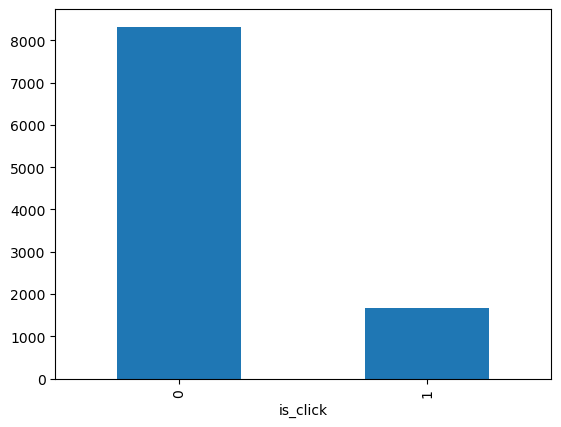

In [96]:
df['is_click'].value_counts().plot(kind='bar')

In [97]:


dtime = pd.DataFrame(df['date'].unique())
dtime['weekday'] = dtime.iloc[:,0].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date().weekday())
dtime

,0,weekday
0,2018-09-18,1
1,2018-09-19,2


In [98]:
df.groupby('date')['is_click'].mean()

date
2018-09-18    0.168404
2018-09-19    0.164029
Name: is_click, dtype: float64

In [99]:
print('item_brand_id ',df['item_brand_id'].unique().size)
print('item_id ',df['item_id'].unique().size)
print('item_price_level ',df['item_price_level'].unique().size)


item_brand_id  944
item_id  2813
item_price_level  10


In [100]:
df.groupby('item_id')['is_click'].mean().head().reset_index()


,item_id,is_click
0,1097631460775571,0.0
1,1637165183538885,0.0
2,10102212873966760,0.4
3,13831602287370737,0.0
4,13847980288352425,0.0


### Train test split

In [101]:
df_train = df[df['date']!='2018-09-24']
df_test = df[df['date']=='2018-09-24']

### Transform data

In [102]:
CATEGORICAL_FEATURES = ['item_city_id','user_gender_id','user_occupation_id']
CONTINUOUS_FEATURES = ['item_price_level', 'item_sales_level', 'item_collected_level','item_pv_level', 'user_age_level', 'user_star_level', 'shop_review_num_level', 'shop_review_positive_rate',
                       'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
VECTOR_FEATURES = ['item_category_list']

### Train GBDT model

In [105]:
def get_continuous_features(data):
    return data[CONTINUOUS_FEATURES]

def get_labels(data):
    return data['is_click']

def get_categorical_features(data):
    enc = OneHotEncoder()
    enc.fit(data)
    return enc.transform(data).toarray()

def get_vector_features(train_data, test_data):
    train_fea , test_feat = None, None    
    for key in VECTOR_FEATURES:        
        c_vector = CountVectorizer()
        c_vector.fit(pd.concat([train_data[key], test_data[key]]))
        if train_fea is None:
            train_fea = c_vector.transform(train_data[key]).toarray()
            test_fea = c_vector.transform(test_data[key]).toarray()
        else:
            train_fea = np.stack([train_fea,c_vector.transform(train_data[key]).toarray()])
            test_fea = np.stack([test_fea,c_vector.transform(test_data[key]).toarray()])
    return train_fea, test_fea

y_train_label = get_labels(df_train)
X_train_gbdt = get_continuous_features(df_train)

y_test_label = get_labels(df_test)
X_test_gbdt = get_continuous_features(df_test)

x_train_category = get_categorical_features(df_train)
# x_test_category = get_categorical_features(df_test)

X_train_vector, X_test_vector = get_vector_features(df_train, df_test)

In [ ]:
gbdt = GradientBoostingClassifier(n_estimators=50, max_depth=4, random_state=0, verbose=1)
gbdt.fit(X_train_gbdt, y_train_label)

      Iter       Train Loss   Remaining Time 
         1           0.8821            8.96s
         2           0.8756            9.56s
         3           0.8704            9.10s
         4           0.8660            8.66s
         5           0.8627            8.43s
         6           0.8595            8.31s
         7           0.8568            8.48s
         8           0.8546            8.30s
         9           0.8524            8.14s
        10           0.8505            7.92s
        20           0.8382            5.80s
        30           0.8307            4.88s
        40           0.8258            2.57s
        50           0.8217            0.00s


GradientBoostingClassifier(max_depth=4, n_estimators=50, random_state=0,
                           verbose=1)

In [116]:
indexs = gbdt.apply(X_train_gbdt) # leave indexes
indexs_train = np.squeeze(indexs)
oneHotEncoder = OneHotEncoder()
oneHotEncoder.fit(indexs_train)
indexs_train_one_hot = oneHotEncoder.transform(indexs_train).toarray()
print(indexs_train_one_hot.shape)

# indexs_t = gbdt.apply(X_test_gbdt) # leave indexes
# indexs_test = np.squeeze(indexs_t)
# oneHotEncoder.fit(indexs_test)
# indexs_test_one_hot = oneHotEncoder.transform(indexs_test)
# print(indexs_test_one_hot.shape)

(10000, 733)


c:\Users\Michael\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


### Train logistic regression model

In [118]:
# feed continuous features, categorical features and vector features into the logistic regression model
X_train_lr = np.hstack((X_train_vector, x_train_category, indexs_train_one_hot))
logisticModel = LogisticRegression(C=100, max_iter=50, n_jobs=8)
logisticModel.fit(X_train_lr, y_train_label)

In [ ]:
# import numpy as np
# a =[[1],[2],[3]]
# b =[[1],[2],[3]]
# c =[[1],[2],[3]]
# print(np.hstack((a,b,c)))



[[1 1 1]
 [2 2 2]
 [3 3 3]]


### Evaluate model

### Predit on test dataset


### Output

In [ ]:

# df = pd.DataFrame()
# df.to_csv('submission.csv',index = False, header=True)